In [46]:
%matplotlib notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms, datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat
import numpy as np
import argparse
import os
from data import build_mprage
from train import train
from metrics import dice
from models.unet import UNet

%load_ext autoreload
%autoreload 2

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
pre_train_mean = 0.4
pre_train_std = 0.25

In [10]:
transform_train =  transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize(256),
                                        transforms.RandomCrop(256, padding=32),
                                        transforms.RandomAffine((-15,15), shear=(-5,5)),
                                        transforms.RandomVerticalFlip(),
                                        transforms.ToTensor(),
#                                         transforms.Normalize(pre_train_mean, pre_train_std)
                                    ])

transform_val = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize(256),
                                    transforms.ToTensor(),
#                                     transforms.Normalize(pre_train_mean, pre_train_std)
                                ])

## Train a model

In [23]:
args ={'image_size': 128, 'dim': 3, 'channels': 1, 'classes': 28, 'depth': 4, 'filters': 32, 'norm': 'batchnorm', 'dropout': 0.0, 'name': 'UNet', 'batch_size': 8, 'epochs': 10, 'learning_rate': 0.003, 'gamma': 0.7, 'gpu': '0', 'seed': 42}

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [25]:
train_set    = build_mprage(root='/scratch/mplatscher/imaging_data/', train=True, train_size=0.8, transform=None)
val_set      = build_mprage(root='/scratch/mplatscher/imaging_data/', train=False, train_size=0.8, transform=None)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=1)
val_loader   = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=1)

In [26]:
model = UNet(**args).to(device)

In [27]:
epochs = 10
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1E-4)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

## load a trained model

In [28]:
PATH = 'data/UNet.pt'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [68]:
ids = 12

In [70]:
im = torch.tensor(val_set[ids][0][np.newaxis,...], dtype=torch.float).to(device)
out = model(im.to(device))
prediction = torch.argmax(out, dim=1)
target = val_set[ids][1]

<IPython.core.display.Javascript object>


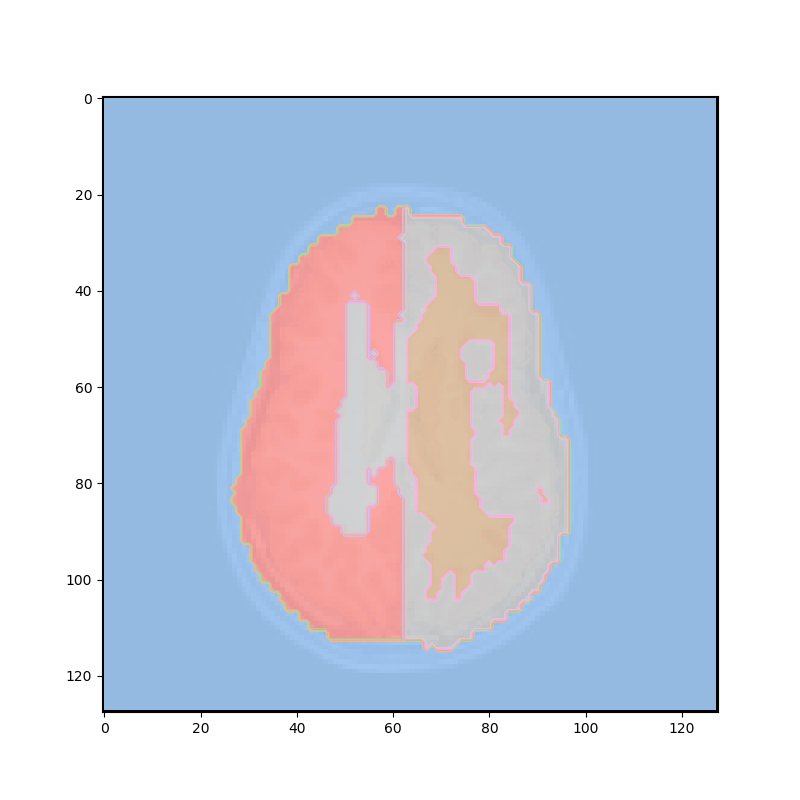

In [76]:
plt.figure(figsize=(8,8))

slc=74

plt.imshow(im.cpu().numpy().squeeze()[:,::-1,slc].T, cmap='bone')

plt.contourf(target.squeeze()[:,::-1,slc].T, alpha=0.3, levels = range(args['classes']), colors=list(sns.color_palette('pastel', args['classes'])))
plt.contourf(prediction.detach().cpu().numpy().squeeze()[:,::-1,slc].T, alpha=0.9, colors=list(sns.color_palette('pastel', args['classes'])))
# # plt.contour(prediction[0,1,...].detach().cpu().numpy().squeeze().T, levels=[0.3, 0.5, 0.7], colors=['r'], linewidths=[0.5])

In [53]:
dice(out, target.to(device).view((1,1,256,256)).long())

tensor([0.8446, 0.4240], device='cuda:0', grad_fn=<MeanBackward1>)

In [21]:
torch.where(prediction[0,1] > 0.5)[0].shape

torch.Size([9465])

In [54]:
torch.sum(target == 1)

tensor(0)

In [23]:
pred = torch.softmax(prediction, dim=1)

In [24]:
torch.argmax(prediction, 1).unsqueeze(1).shape

torch.Size([1, 1, 256, 256])

In [25]:
(torch.argmax(prediction,dim=1)[0] * target.to(device)).sum() / (torch.argmax(prediction,dim=1)[0] + target.to(device)).sum()

tensor(0.4053, device='cuda:0')

In [26]:
torch.argmax(prediction,dim=1).shape

torch.Size([1, 256, 256])

In [27]:
for data, label in val_loader:
    data = torch.as_tensor(data.to(device), dtype=torch.float)
    label = torch.as_tensor(label.to(device), dtype=torch.int64)
    
    output = model(data)
    print(dice(output, label))

tensor([0.8126, 0.4051], device='cuda:0', grad_fn=<MeanBackward1>)
tensor([0.8115, 0.3095], device='cuda:0', grad_fn=<MeanBackward1>)
tensor([0.8136, 0.3247], device='cuda:0', grad_fn=<MeanBackward1>)
tensor([0.8156, 0.3243], device='cuda:0', grad_fn=<MeanBackward1>)
tensor([0.8121, 0.3203], device='cuda:0', grad_fn=<MeanBackward1>)
tensor([0.8171, 0.3315], device='cuda:0', grad_fn=<MeanBackward1>)
tensor([0.8181, 0.3088], device='cuda:0', grad_fn=<MeanBackward1>)
tensor([0.8185, 0.3321], device='cuda:0', grad_fn=<MeanBackward1>)
tensor([0.8144, 0.3518], device='cuda:0', grad_fn=<MeanBackward1>)
tensor([0.8165, 0.2971], device='cuda:0', grad_fn=<MeanBackward1>)
tensor([0.8160, 0.3423], device='cuda:0', grad_fn=<MeanBackward1>)
tensor([0.8125, 0.4034], device='cuda:0', grad_fn=<MeanBackward1>)
tensor([0.8157, 0.3386], device='cuda:0', grad_fn=<MeanBackward1>)
tensor([0.8150, 0.3426], device='cuda:0', grad_fn=<MeanBackward1>)
tensor([0.8096, 0.3294], device='cuda:0', grad_fn=<MeanBackwar

In [42]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /home/mplatscher/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /home/mplatscher/.cache/torch/hub/checkpoints/unet-e012d006.pt
